## Architecture of a Classification NN

# Input layer shape (in_features)

Same as number of features (age, sex, height,...)

# Hidden layer(s)

Depends on the problem, min = 1, max = unlimited

# Neurons per hidden layer

Also dpends on the problem, it's normally 10-512

# Output layer shape (out_features)

1 (one class or the other for binary) and 1 per class for multiclass probs

# Hidden layer activation

Usually ReLu but can be many others

# Output Activation

Sigmoid/Softmax

# Loss Function

Binary crossentropy/ Cross Entropy

# Optimiser

SGD,Adam

## Some popular activation function

# Sigmoid

(aka Logistic function)

Smooth gradient, output values bound between 0 and 1 -> normalise the output of neurons

Clear Predictions (mostly for binary)

Vanish Gradient: for extreme values of X, the network learn slower or refust not to learn

Computationally expensive

Not zero centered - So if for layers after the sigmoid output layer, the gradients are only calculated (weights) to be either negative or positive, creating a zig zag pattern in learning the gradient.

# Tanh function

Same with Sigmoid but its output is centered at zero

# ReLu (common choice of AF)

Computational efficient

But if the input is negative, or near zero, the gradient of the function become zero -> backprop cannot be perform hence the network doesn't learn anymore.

-> To fix this, we have leaky ReLu




## 1. Make classification data

Being by using make_circles() method from Scikit-Learn to generate two circles with different coloured dots

In [5]:
from sklearn.datasets import make_circles

In [6]:
n_samples = 1000

x,y = make_circles(n_samples,
                   noise = 0.05,
                   random_state=42)

In [7]:
print(f"First 5 X features:\n{x[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.74220688  0.24668576]
 [-0.7340323   0.16869164]
 [-0.82985872  0.22195899]
 [-0.42913559  0.67223019]
 [ 0.44560223 -0.89493556]]

First 5 y labels:
[1 1 1 1 0]


In [8]:
import pandas as pd
circles = pd.DataFrame({"X1": x[:, 0],
    "X2": x[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.742207,0.246686,1
1,-0.734032,0.168692,1
2,-0.829859,0.221959,1
3,-0.429136,0.672230,1
4,0.445602,-0.894936,0
5,-0.469885,0.708037,1
6,-0.016045,0.805623,1
7,0.759623,0.159526,1
8,-0.175692,-0.799837,1
9,-0.110616,1.042207,0


In [10]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

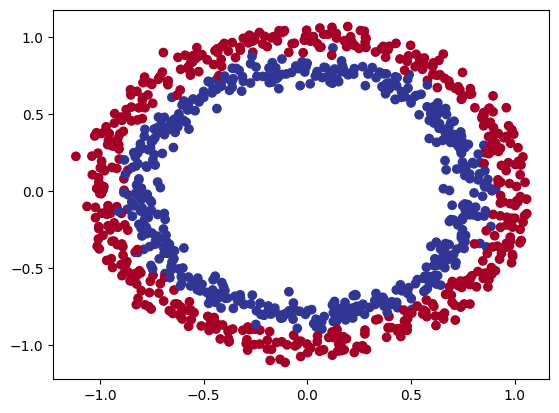

In [12]:
import matplotlib.pyplot as plt
plt.scatter(x=x[:, 0], 
            y=x[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [13]:
# Now we start to build the architecture for the NN model

## Input and output shapes

In [14]:
x.shape,y.shape

((1000, 2), (1000,))

## Turn data into tensors and split train/test sets


In [15]:
import torch
X = torch.from_numpy(x).type(torch.float)
Y = torch.from_numpy(y).type(torch.float)

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = 0.25, random_state = 42)

In [18]:
len(x_train), len(y_train), len(x_test), len(y_test)

(750, 750, 250, 250)

In [19]:
import torch
from torch import nn

In [20]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features = 5)
        self.layer_2 = nn.Linear(in_features = 5, out_features = 1)
        
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

In [25]:
model_0 = CircleModelV0().to("cpu")
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [26]:
#Alternatively to CircleModelV0 we can use nn.Sequential

model_0_v2 = nn.Sequential(
    nn.Linear(in_features = 2, out_features =5),
    nn.Linear(in_features = 5, out_features = 1),
).to("cpu")

model_0_v2

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [28]:
untrained_preds = model_0(x_test)
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 250, Shape: torch.Size([250, 1])
Length of test samples: 250, Shape: torch.Size([250])

First 10 predictions:
tensor([[-0.0062],
        [ 0.1706],
        [-0.4599],
        [ 0.1381],
        [-0.4805],
        [-0.3649],
        [ 0.1449],
        [ 0.0265],
        [-0.4856],
        [ 0.1784]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [31]:
loss_fn = nn.BCEWithLogitsLoss()

optimiser = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

In [52]:
# torch.eq() calculates where two tensors are equal

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred))
    return acc
    

## Now we train the model

In [87]:
torch.manual_seed(42)

epochs = 100

train_lost_values = []
test_lost_values = []
epoch_count = []

for epoch in range(epochs):
    model_0.train()
    
    y_logits = model_0(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    #calulate the loss
    loss = loss_fn(y_logits,y_train)
        
    acc = accuracy_fn(y_true = y_train, y_pred = y_pred)
    
    optimiser.zero_grad()
    
    loss.backward()
    
    optimiser.step()
    
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)
        
    if epoch % 10 ==0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
    
    

Epoch: 0 | Loss: 2511.34595, Accuracy: 0.52% | Test loss: 681.11292, Test acc: 0.52%
Epoch: 10 | Loss: 94999194849314016752882941952.00000, Accuracy: 0.49% | Test loss: 97875475768370829766117604458496.00000, Test acc: 0.49%
Epoch: 20 | Loss: nan, Accuracy: 0.00% | Test loss: nan, Test acc: 0.00%
Epoch: 30 | Loss: nan, Accuracy: 0.00% | Test loss: nan, Test acc: 0.00%
Epoch: 40 | Loss: nan, Accuracy: 0.00% | Test loss: nan, Test acc: 0.00%
Epoch: 50 | Loss: nan, Accuracy: 0.00% | Test loss: nan, Test acc: 0.00%
Epoch: 60 | Loss: nan, Accuracy: 0.00% | Test loss: nan, Test acc: 0.00%
Epoch: 70 | Loss: nan, Accuracy: 0.00% | Test loss: nan, Test acc: 0.00%
Epoch: 80 | Loss: nan, Accuracy: 0.00% | Test loss: nan, Test acc: 0.00%
Epoch: 90 | Loss: nan, Accuracy: 0.00% | Test loss: nan, Test acc: 0.00%


we can see that our model perform poorly and indicating underfitting. what we can do right now is to add more layers? add more hidden units? fitting for longer (more epochs)? changing the activation fn? changing the learning rate? changing the loss fn? use transfer learning (take a pretrained model from a similar problem domain)

In [41]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to("cpu")
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [42]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [44]:
torch.manual_seed(42)
epochs = 1000

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    
    model_1.train()
    
    y_logits = model_1(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(x_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69515, Accuracy: 0.01% | Test loss: 0.69350, Test acc: 0.00%
Epoch: 100 | Loss: 0.69320, Accuracy: 0.01% | Test loss: 0.69319, Test acc: 0.00%
Epoch: 200 | Loss: 0.69302, Accuracy: 0.01% | Test loss: 0.69377, Test acc: 0.01%
Epoch: 300 | Loss: 0.69296, Accuracy: 0.01% | Test loss: 0.69412, Test acc: 0.00%
Epoch: 400 | Loss: 0.69293, Accuracy: 0.01% | Test loss: 0.69435, Test acc: 0.00%
Epoch: 500 | Loss: 0.69292, Accuracy: 0.01% | Test loss: 0.69451, Test acc: 0.00%
Epoch: 600 | Loss: 0.69292, Accuracy: 0.01% | Test loss: 0.69462, Test acc: 0.00%
Epoch: 700 | Loss: 0.69291, Accuracy: 0.01% | Test loss: 0.69469, Test acc: 0.00%
Epoch: 800 | Loss: 0.69291, Accuracy: 0.01% | Test loss: 0.69473, Test acc: 0.00%
Epoch: 900 | Loss: 0.69291, Accuracy: 0.01% | Test loss: 0.69476, Test acc: 0.00%


In [ ]:
#But we have to consider the fact that the data is not linear

In [59]:
# Build model with non-linear activation function, after each layer except for the output layer, a reLu function is activated
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2()
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [60]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [61]:
# Fit the model
torch.manual_seed(42)
epochs = 5000

for epoch in range(epochs):
    
    model_3.train()
    # 1. Forward pass
    y_logits = model_3(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(x_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69286, Accuracy: 0.5053333333333333% | Test Loss: 0.69348, Test Accuracy: 0.48%
Epoch: 100 | Loss: 0.69119, Accuracy: 0.6493333333333333% | Test Loss: 0.69150, Test Accuracy: 0.60%
Epoch: 200 | Loss: 0.68976, Accuracy: 0.688% | Test Loss: 0.69006, Test Accuracy: 0.68%
Epoch: 300 | Loss: 0.68784, Accuracy: 0.5946666666666667% | Test Loss: 0.68810, Test Accuracy: 0.60%
Epoch: 400 | Loss: 0.68504, Accuracy: 0.5666666666666667% | Test Loss: 0.68532, Test Accuracy: 0.58%
Epoch: 500 | Loss: 0.68087, Accuracy: 0.5706666666666667% | Test Loss: 0.68138, Test Accuracy: 0.58%
Epoch: 600 | Loss: 0.67510, Accuracy: 0.5813333333333334% | Test Loss: 0.67607, Test Accuracy: 0.58%
Epoch: 700 | Loss: 0.66674, Accuracy: 0.6226666666666667% | Test Loss: 0.66854, Test Accuracy: 0.60%
Epoch: 800 | Loss: 0.65366, Accuracy: 0.66% | Test Loss: 0.65746, Test Accuracy: 0.68%
Epoch: 900 | Loss: 0.63019, Accuracy: 0.7093333333333334% | Test Loss: 0.63722, Test Accuracy: 0.70%
Epoch: 1000 | Loss:

In [64]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


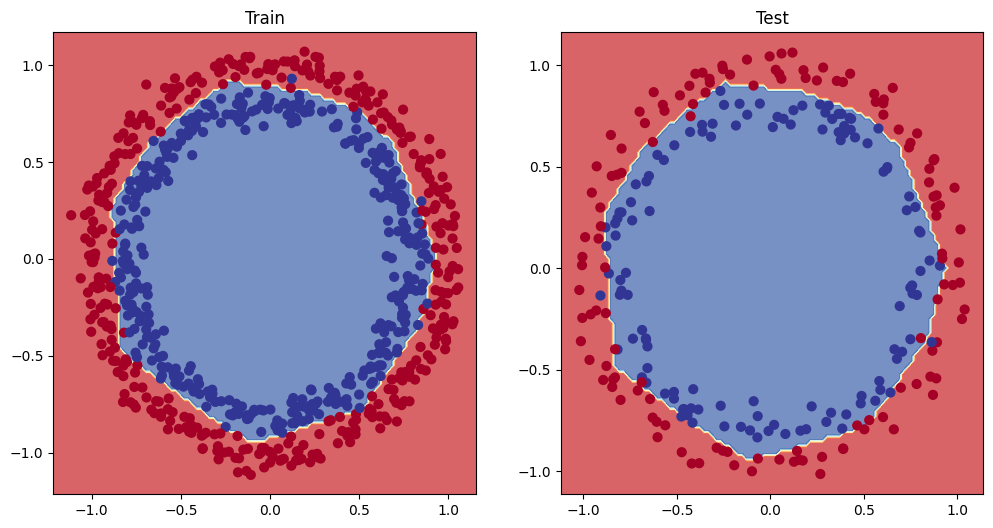

In [67]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, x_test, y_test)

## Now, Let's go for multi-class classification data


tensor([[ -6.3093,  -5.9642],
        [  2.5286,   0.8064],
        [ -7.6808,   3.0507],
        [ -6.0399,  -5.2589],
        [-10.5505,  10.0461]]) tensor([2, 1, 3, 2, 5])


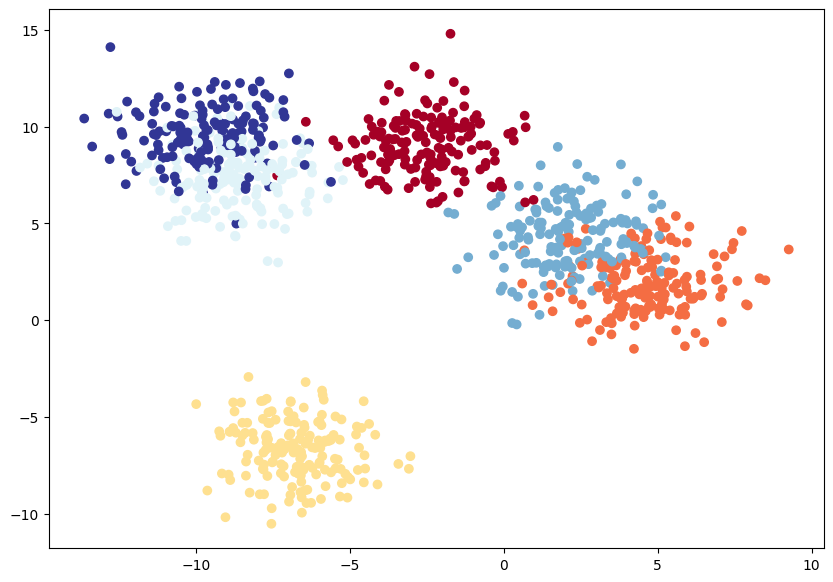

In [69]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 6
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [70]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to("cpu")
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=6, bias=True)
  )
)

In [73]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [75]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to("cpu"))[:5]

tensor([[-0.2014, -0.2812, -0.2012,  0.1141,  0.3873, -0.5601],
        [-0.4241, -0.7340, -0.6409,  0.0644,  0.7044, -0.6083],
        [-0.1456, -0.1191,  0.0674,  0.1878,  0.3330, -0.3030],
        [-1.1538, -0.5677, -1.6362, -0.8624,  0.6471, -0.7148],
        [-0.7128, -1.3563, -1.3454, -0.1610,  0.8438, -1.0740]],
       grad_fn=<SliceBackward0>)

In [76]:
model_4(X_blob_train.to("cpu"))[0].shape, NUM_CLASSES

(torch.Size([6]), 6)

This is where we use softmax to convert the prob of each prediction class being the actual predicted class compared to all other possible classes

In [77]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to("cpu"))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.8078, -0.4018, -1.1254, -0.6082,  0.4908, -0.7248],
        [-0.8276, -0.4107, -1.1588, -0.6310,  0.4930, -0.7369],
        [-0.1403, -0.1479, -0.0286,  0.2024,  0.4308, -0.3655],
        [-0.4456, -0.7827, -0.6877,  0.0533,  0.7338, -0.6193],
        [-0.6334, -1.1637, -1.2046, -0.1517,  0.6304, -1.1639]],
       grad_fn=<SliceBackward0>)
tensor([[0.1087, 0.1631, 0.0791, 0.1327, 0.3983, 0.1181],
        [0.1076, 0.1633, 0.0773, 0.1310, 0.4031, 0.1178],
        [0.1411, 0.1400, 0.1578, 0.1988, 0.2497, 0.1126],
        [0.1214, 0.0866, 0.0953, 0.1999, 0.3948, 0.1020],
        [0.1266, 0.0745, 0.0715, 0.2049, 0.4480, 0.0745]],
       grad_fn=<SliceBackward0>)


In [78]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [79]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1087, 0.1631, 0.0791, 0.1327, 0.3983, 0.1181],
       grad_fn=<SelectBackward0>)
tensor(4)


In [81]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.77720, Acc: 0.18% | Test Loss: 1.72082, Test Acc: 0.12%
Epoch: 10 | Loss: 1.20338, Acc: 0.58% | Test Loss: 1.16903, Test Acc: 0.66%
Epoch: 20 | Loss: 0.86957, Acc: 0.78% | Test Loss: 0.84714, Test Acc: 0.71%
Epoch: 30 | Loss: 0.73047, Acc: 0.79% | Test Loss: 0.71766, Test Acc: 0.72%
Epoch: 40 | Loss: 0.65124, Acc: 0.80% | Test Loss: 0.64718, Test Acc: 0.73%
Epoch: 50 | Loss: 0.59924, Acc: 0.80% | Test Loss: 0.60233, Test Acc: 0.75%
Epoch: 60 | Loss: 0.56054, Acc: 0.81% | Test Loss: 0.57036, Test Acc: 0.76%
Epoch: 70 | Loss: 0.52957, Acc: 0.82% | Test Loss: 0.54549, Test Acc: 0.78%
Epoch: 80 | Loss: 0.50389, Acc: 0.83% | Test Loss: 0.52520, Test Acc: 0.79%
Epoch: 90 | Loss: 0.48248, Acc: 0.82% | Test Loss: 0.50672, Test Acc: 0.84%


In [82]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-3.0003e+00,  5.0711e+00, -4.8313e+00, -8.9980e+00,  3.9326e+00,
         -5.1943e+00],
        [-3.0474e+00,  5.1808e+00, -5.0000e+00, -9.2575e+00,  4.0435e+00,
         -5.3362e+00],
        [-4.4731e-01, -4.0701e-01,  1.5660e+00, -1.8859e-01, -1.6392e-01,
         -5.6131e-01],
        [-1.0569e-01, -5.2138e+00, -2.2446e+00,  3.0578e+00, -2.6763e+00,
          3.9097e+00],
        [ 4.3120e+00, -8.6651e+00, -7.6429e+00, -5.3435e+00,  8.8515e-01,
         -2.0959e+00],
        [-1.9590e-02, -5.6640e-01, -7.7178e+00, -1.0147e+01,  3.9686e+00,
         -5.5778e+00],
        [ 4.8287e-03, -8.8193e+00, -4.6791e+00,  5.1179e+00, -4.5944e+00,
          7.0607e+00],
        [-5.3671e+00,  9.0095e+00, -7.2267e+00, -1.2086e+01,  4.8697e+00,
         -6.1739e+00],
        [-4.4731e-01, -4.0701e-01,  1.5660e+00, -1.8859e-01, -1.6392e-01,
         -5.6131e-01],
        [-4.4943e+00,  7.4731e+00, -5.9525e+00, -1.0323e+01,  4.2421e+00,
         -5.4210e+00]])

In [83]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 1, 2, 5, 0, 4, 5, 1, 2, 1])
Labels: tensor([1, 1, 2, 3, 0, 4, 5, 1, 2, 1])
Test accuracy: 0.725%


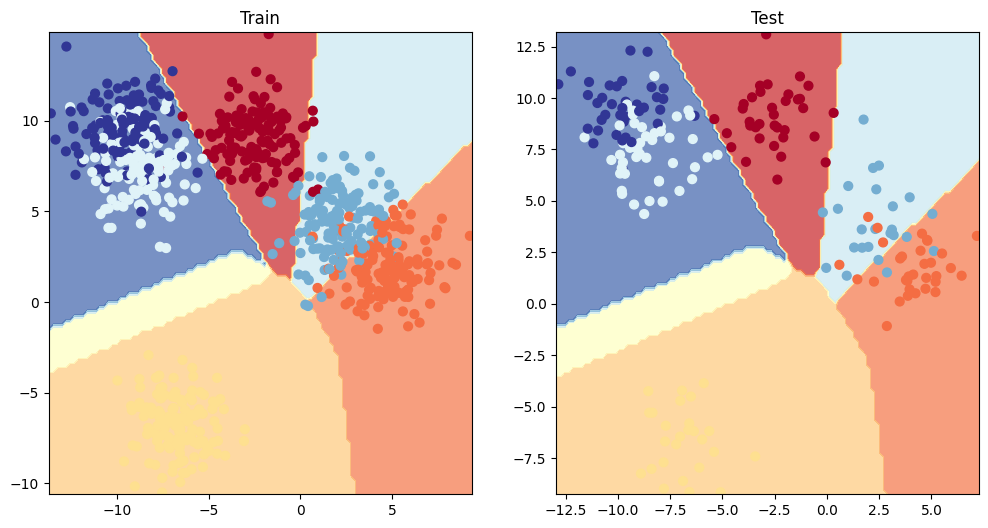

In [84]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [86]:
from pathlib import Path

def save_models(name, model):
    
    MODEL_PATH = Path("models")
    MODEL_PATH.mkdir(parents=True, exist_ok = True)

    MODEL_NAME = name
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

    print(f"Saveing model to: {MODEL_SAVE_PATH}")
    torch.save(obj = model.state_dict(), f=MODEL_SAVE_PATH)
    
save_models('02_pytorch_nn_classification_3.pth', model_3)
save_models('02_pytorch_nn_classification_4.pth',model_4)

Saveing model to: models/02_pytorch_nn_classification_3.pth
Saveing model to: models/02_pytorch_nn_classification_4.pth
